In [2]:
import os
from os.path import abspath, dirname
import shutil as sh
from io import StringIO
from icecream import ic
import fitz

from PIL import Image
from matplotlib import pyplot as plt 
import pytesseract
import numpy as np
import cv2
import pandas as pd
from collections import defaultdict
import statistics

### Image extraction from PDF 

In [139]:
def extract_img(file_name, save_img):
    sh.rmtree(save_img)  # delete this folder
    # if file don't exist, then create
    try:
        os.makedirs(save_img)
    except:
        print ("Directory already exist.")

    img_count = 0
    file_name1, _ = os.path.splitext(file_name)
    absolute_path = os.path.join(folder_path, file_name)

    doc = fitz.open(absolute_path)  # Document('.pdf')
    lenXREF = doc.xref_length()  # the number of entries in the xref table (cross-reference number)
    print(f'file name: {file_name}, the number of pages: {len(doc)}, length of xref table: {lenXREF - 1}')

    # extract images from each pages
    for idx, page in enumerate(doc): 
        imgs_list = page.get_images()  # the number of images in each page  
        for i in imgs_list:
            single_img = list(i)  # tuple -> list          
            xref = single_img[0]   
            img = doc.extract_image(xref)  # get image info

            # delete too small images, that may not be a chart
            pix = fitz.Pixmap(doc, xref)
            if pix.size < 10000: continue 
            img_count += 1

            # add images into folder
            img_name = f'{img_count}_p{idx+1}.' + img["ext"]  
            img_name = file_name1 + "_" + img_name
            img_path = os.path.join(save_img, img_name)   
            
            img_out = open(img_path, 'wb')   
            img_out.write(img["image"])   
            img_out.close

    print(f'Extraction finished. Total images: {img_count}')


file_name = 'sample5.pdf'
folder_path = abspath(dirname(file_name))  # get the direction
save_img = folder_path + '/imagesss'

extract_img(file_name, save_img)

file name: sample5.pdf, the number of pages: 54, length of xref table: 1326
Extraction finished. Total images: 4


## Line chart

### No image preprocessing

In [272]:
filename = 'bar_chart.png'
img1 = np.array(Image.open(filename))

# Get verbose data including boxes, confidences, line and page numbers
data = pytesseract.image_to_data(Image.open(filename))

df = pd.read_csv(StringIO(data), sep='\t')
df = df.dropna().reset_index().drop(labels='index', axis=1)
df = df[~df['text'].isin([' ','  ','   '])]
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,15,15,44,12,93.953842,Chart
1,5,1,1,1,1,2,66,16,40,11,95.944832,5.2.1
2,5,1,1,1,2,1,16,33,63,12,96.389694,Number
3,5,1,1,1,2,2,85,33,16,12,96.956291,of
4,5,1,1,1,2,3,107,37,44,11,96.949677,police
5,5,1,1,1,2,4,157,33,59,12,96.866447,officers
6,5,1,1,1,2,5,222,33,13,12,96.866447,in
7,5,1,1,1,2,6,241,33,47,12,6.817482,Crime
9,5,1,3,1,1,1,311,37,14,11,91.851128,"le,"
10,5,1,3,1,1,2,332,34,41,11,93.726814,2011


In [273]:
# title lies on the top-most of the chart in most cases
# title = df[df.top == df.top.min()].text.values
title = df[df.top == sorted(set(df.top.values))[2]].text.values
title = ' '.join(title)
ic(title)

# y label lies on the left-most of the chart in most cases, adjacent to y-axis
y_label = df[df.left == df.left.min()].text.values
y_label = ' '.join(y_label)
y_axis = df[df.left == sorted(set(df.left.values))[2]].text.values
ic(y_label, y_axis)

# x label lies on the bottom-most of the chart in most cases, adjacent to x-axis
x_label = df[df.top == df.top.max()].text.values
y_label = ' '.join(x_label)
x_axis = df[df.top == sorted(set(df.top.values))[-2]].text.values
ic(x_label, x_axis)

ic| title: 'Number of officers in Crime'
ic| y_label: 'Chart Number of police officers'
    y_axis: array(['404'], dtype=object)
ic| x_label: array(['Year'], dtype=object)
    x_axis: array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
                   '2019'], dtype=object)


(array(['Year'], dtype=object),
 array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
        '2019'], dtype=object))

### Applying image preprocessing (result is better)

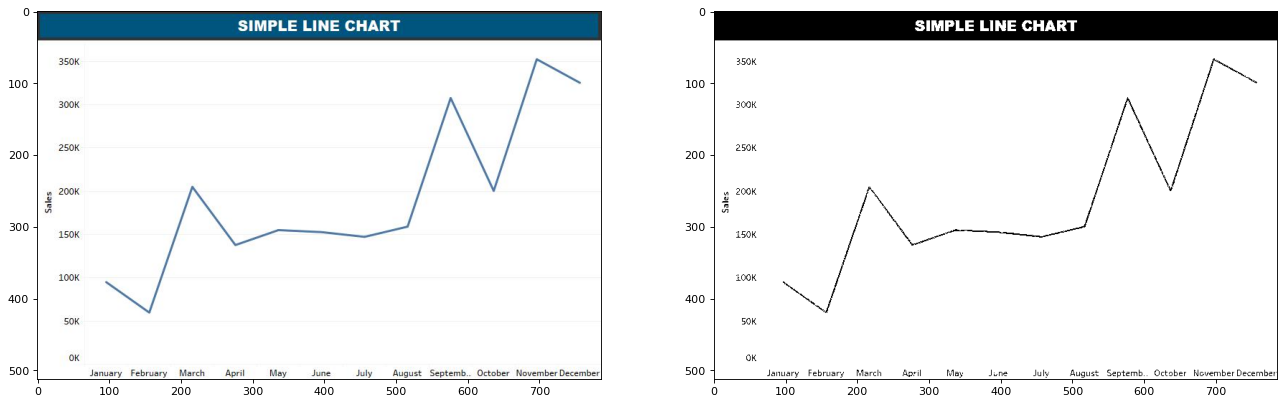

In [3]:
# eliminate noise
def img_preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    norm_img = np.zeros((image.shape[0], image.shape[1]))
    image = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)
    image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)[1]  # > threshold 120, set it to maxval 255 white, otherwise 0 black
    image = cv2.GaussianBlur(image, (1, 1), 0)  # Gaussian Smoothing
    return image


# using PIL show image
def Image_show(original_img, image):
    img_cvt1 = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img_cvt1 = Image.fromarray(img_cvt1)
    img_cvt2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_cvt2 = Image.fromarray(img_cvt2)

    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
    ax[0].imshow(img_cvt1)
    ax[1].imshow(img_cvt2)


# using cv2 show image
# def show(name, img):
#     cv2.imshow(name, img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     cv2.waitKey(1)
# show('image', img)

# original_img = cv2.imread('bar_chart.png')
original_img = cv2.imread('line_chart3.jpeg')

img = img_preprocessing(original_img)
Image_show(original_img, img)

Using pytesseract libray to extract text

In [4]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
data = pytesseract.image_to_data(img_rgb)

# convert to dataframe and delete nan values and blank spaces
df = pd.read_csv(StringIO(data), sep='\t')
df = df.dropna().reset_index().drop(labels='index', axis=1)
df = df[~df['text'].isin([' ','  ','   '])]
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
1,5,1,2,1,1,1,32,66,27,9,88.847137,350K
2,5,1,3,1,1,1,31,126,28,9,92.008308,300K
3,5,1,4,1,1,1,31,186,28,9,95.400139,250K
4,5,1,5,1,1,1,31,247,28,9,95.509254,200K
5,5,1,6,1,1,1,11,252,9,29,84.858917,Sales
7,5,1,8,1,1,1,31,367,28,9,78.478790,200K
8,5,1,9,1,1,1,39,428,20,9,75.057755,50K
9,5,1,10,1,1,1,45,479,14,9,53.362679,OK
10,5,1,11,1,1,1,96,377,45,33,0.000000,N\
11,5,1,12,1,1,1,74,500,44,11,74.081680,January


Extracting axis info

In [5]:
# title lies on the top-most of the chart in most cases
title = df[df.top == df.top.min()].text.values
# title = df[df.top == sorted(set(df.top.values))[2]].text.values
title = ' '.join(title)
ic(title)


# y label lies on the left-most of the chart in most cases, adjacent to y-axis
y_label = df[df.left == df.left.min()].text.values
y_label = ' '.join(y_label)

set_point = sorted(set(df.left.values))[2]
error_tol1 = set_point - 1  # Error tolerance
error_tol2 = set_point + 1
# y_axis = df[df.left == set_point].text.values
y_df = df.query('30 < left < 40')
y_axis = y_df.text.values
# y_axis = list(map(lambda x: int(x), y_axis))  # str -> int 
y_top_pixel = y_df.top.values
y_h_pixel = y_df.height.values
ic(y_label, y_axis, y_top_pixel, y_h_pixel)  # 0 was not recognized

# x label lies on the bottom-most of the chart in most cases, adjacent to x-axis
# x_label = df[df.top == df.top.max()].text.values
# x_label = ' '.join(x_label)

# x_df = df[df.top == sorted(set(df.top.values))[-2]]
x_df = df.query('490 <= top')
x_axis = x_df.text.values
x_left_pixel = x_df.left.values 
x_w_pixel = x_df.width.values 
# ic(x_label, x_axis, x_left_pixel, x_w_pixel)
ic(x_axis, x_left_pixel, x_w_pixel)

ic| title: 'SIMPLE LINE CHART'
ic| y_label: 'Sales'
    y_axis: array(['350K', '300K', '250K', '200K', '200K', '50K'], dtype=object)
    y_top_pixel: array([ 66, 126, 186, 247, 367, 428])
    y_h_pixel: array([9, 9, 9, 9, 9, 9])
ic| x_axis: array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
                   '‘August', 'Septemb.', 'October', 'November', 'December'],
                  dtype=object)
    x_left_pixel: array([ 74, 132, 199, 263, 325, 383, 445, 496, 548, 614, 669, 730])
    x_w_pixel: array([44, 49, 34, 25, 21, 26, 21, 40, 49, 44, 56, 52])


(array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
        '‘August', 'Septemb.', 'October', 'November', 'December'],
       dtype=object),
 array([ 74, 132, 199, 263, 325, 383, 445, 496, 548, 614, 669, 730]),
 array([44, 49, 34, 25, 21, 26, 21, 40, 49, 44, 56, 52]))

find real x and y piexel value

x_real_pixel = x_left_pixel + x_w_pixel / 2

y_real_pixel = y_top_pixel + y_h_pixel / 2

In [6]:
x_real_pixel = x_left_pixel + x_w_pixel / 2
y_real_pixel = y_top_pixel + y_h_pixel / 2
ic(x_real_pixel, y_real_pixel)

ic| x_real_pixel: array([ 96. , 156.5, 216. , 275.5, 335.5, 396. , 455.5, 516. , 572.5,
                         636. , 697. , 756. ])
    y_real_pixel: array([ 70.5, 130.5, 190.5, 251.5, 371.5, 432.5])


(array([ 96. , 156.5, 216. , 275.5, 335.5, 396. , 455.5, 516. , 572.5,
        636. , 697. , 756. ]),
 array([ 70.5, 130.5, 190.5, 251.5, 371.5, 432.5]))

In [7]:
x_axis[7] = 'August'

# y_axis incomplete, so calculate it according to other value
# y_axis = y_axis.tolist()
# y_axis.append('0')
y_axis[0] = 350000

diff = []
for i in range(1, len(y_real_pixel)):
    dif = int(y_real_pixel[i]) - int(y_real_pixel[i-1])
    diff.append(dif)

ic(diff)  # if not same, get the mean value

mode = max(set(diff), key=diff.count)

y_real_pixel = y_real_pixel.tolist()
y_axis = y_axis.tolist()
y_axis.pop()
y_axis.pop()
y_axis.append('150K')
y_axis.append('100K')
y_axis.append('50K')
y_axis.append(0)
y_real_pixel.pop()
y_real_pixel.pop()

for i in range(4):
    y_real_pixel.append(y_real_pixel[-1] + mode)

y_pixel_max = y_real_pixel[-1]
ic(x_axis, y_axis, y_real_pixel, y_pixel_max)

ic| diff: [60, 60, 61, 120, 61]
ic| x_axis: array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
                   'August', 'Septemb.', 'October', 'November', 'December'],
                  dtype=object)
    y_axis: [350000, '300K', '250K', '200K', '150K', '100K', '50K', 0]
    y_real_pixel: [70.5, 130.5, 190.5, 251.5, 311.5, 371.5, 431.5, 491.5]
    y_pixel_max: 491.5


(array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
        'August', 'Septemb.', 'October', 'November', 'December'],
       dtype=object),
 [350000, '300K', '250K', '200K', '150K', '100K', '50K', 0],
 [70.5, 130.5, 190.5, 251.5, 311.5, 371.5, 431.5, 491.5],
 491.5)

### Canny Edge Detection

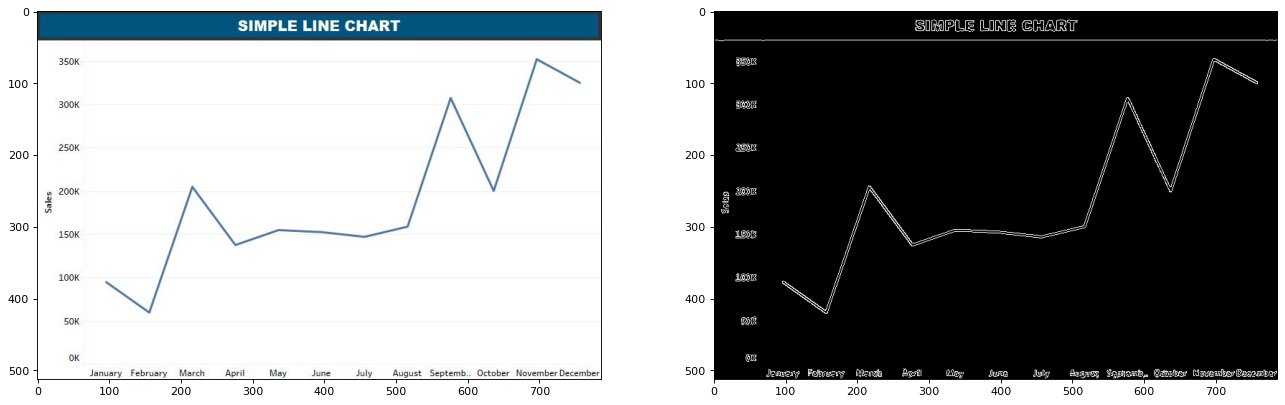

In [8]:
gray= cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
edges= cv2.Canny(gray, 50, 200)
# _, edges = cv2.threshold(gray, 150, 200, cv2.THRESH_BINARY)  # apply binary thresholding
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

Image_show(original_img, edges)

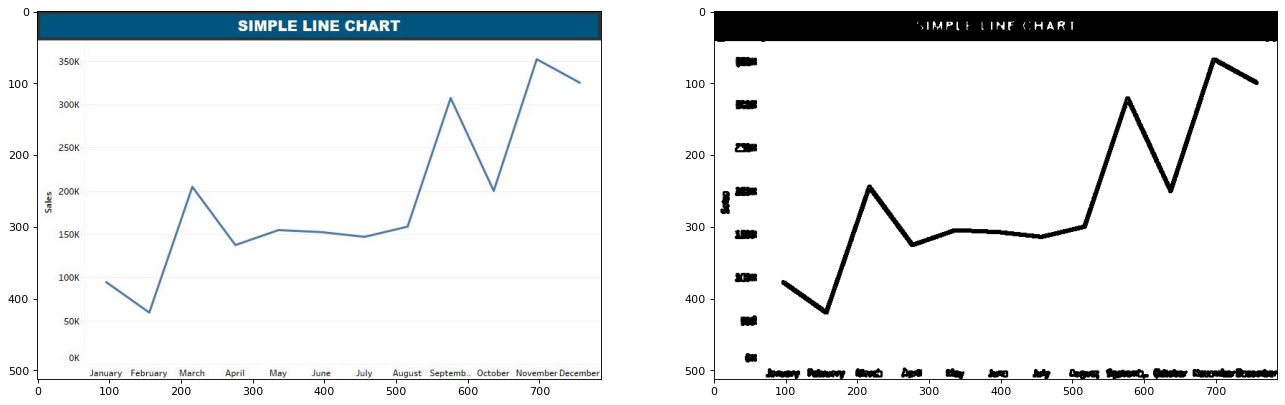

In [31]:
# draw the contours
tmp = cv2.drawContours(img, contours, -1, (0,0,255), 2)  
Image_show(original_img, tmp)

### Calculate real y-axis value based on proportion

### Discrete output value of y

In [32]:
# x correspond to y pixel value
y_dic = defaultdict(list)
for i in contours:
    for j in i:
        if j[0][0] in x_real_pixel and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
            y_dic[j[0][0]].append(j[0][1])

y_dic

defaultdict(list,
            {636: [244, 244, 251, 251],
             516: [294, 295, 296, 302, 302, 296, 295, 294],
             396: [306, 309, 309, 306],
             216: [244, 250, 249, 250, 244],
             96: [376, 380, 379, 376],
             756: [98, 101, 101, 98]})

y axis value of the other month cannot be recognized.

In [10]:
ic(x_real_pixel, y_real_pixel)

ic| x_real_pixel: array([ 96. , 156.5, 216. , 275.5, 335.5, 396. , 455.5, 516. , 572.5,
                         636. , 697. , 756. ])
    y_real_pixel: [70.5, 130.5, 190.5, 251.5, 311.5, 371.5, 431.5, 491.5]


(array([ 96. , 156.5, 216. , 275.5, 335.5, 396. , 455.5, 516. , 572.5,
        636. , 697. , 756. ]),
 [70.5, 130.5, 190.5, 251.5, 311.5, 371.5, 431.5, 491.5])

find which x_axis pixel are missing

In [27]:
x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
x_y_value

exist_value = []
for i in x_y_value:
    exist_value.append(i[0])

missing_value = []
for i in x_real_pixel:
    if i not in exist_value:
        missing_value.append(i)
missing_value

[156.5, 275.5, 335.5, 455.5, 572.5, 697.0]

using the adjacent values to replace missing value

In [28]:
tolerance = 1

missing_value_dic = defaultdict(list)
for i in contours:
    for j in i:
        for m in missing_value:
            if m-tolerance <= j[0][0] <= m+tolerance and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
                missing_value_dic[j[0][0]].append(j[0][1])
                missing_value.remove(m)  # make sure only add one value
                if len(missing_value) == 0:
                    break

# x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
# x_y_value
missing_value_dic

defaultdict(list,
            {573: [124],
             456: [313],
             336: [304],
             276: [323],
             157: [411],
             696: [71]})

In [33]:
y_dic.update(missing_value_dic)
x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
x_y_value

[(96, [376, 380, 379, 376]),
 (157, [411]),
 (216, [244, 250, 249, 250, 244]),
 (276, [323]),
 (336, [304]),
 (396, [306, 309, 309, 306]),
 (456, [313]),
 (516, [294, 295, 296, 302, 302, 296, 295, 294]),
 (573, [124]),
 (636, [244, 244, 251, 251]),
 (696, [71]),
 (756, [98, 101, 101, 98])]

In [34]:
x_y_value_mean = [statistics.mean(i[1]) for i in x_y_value]

# img_w, img_l = original_img.shape[0], original_img.shape[1]
y_pixel_min = y_real_pixel[0]
y_axis_max = int(y_axis[0])
ic(x_y_value_mean, y_pixel_min, y_axis_max)

ic| x_y_value_mean: [377, 411, 247, 323, 304, 307, 313, 296, 124, 247, 71, 99]
    y_pixel_min: 70.5
    y_axis_max: 350000


([377, 411, 247, 323, 304, 307, 313, 296, 124, 247, 71, 99], 70.5, 350000)

y = (y_pixel_max - x_y_value) / (y_pixel_max - y_pixel_min) * y_axis_max


In [35]:
y_axis_value = []
for i in x_y_value_mean:
    y = (y_pixel_max - i) / (y_pixel_max - y_pixel_min) * y_axis_max
    y = round(y, 2)
    y_axis_value.append(y)
y_axis_value

[95190.02,
 66923.99,
 203266.03,
 140083.14,
 155878.86,
 153384.8,
 148396.67,
 162529.69,
 305522.57,
 203266.03,
 349584.32,
 326306.41]

In [36]:
# data = pd.DataFrame(y_label:y_axis_value, columns=x_axis)
data = pd.DataFrame(index=range(1), columns=x_axis)
data.iloc[0:] = y_axis_value
data

,January,February,March,April,May,June,July,August,Septemb.,October,November,December
0,95190.02,66923.99,203266.03,140083.14,155878.86,153384.8,148396.67,162529.69,305522.57,203266.03,349584.32,326306.41


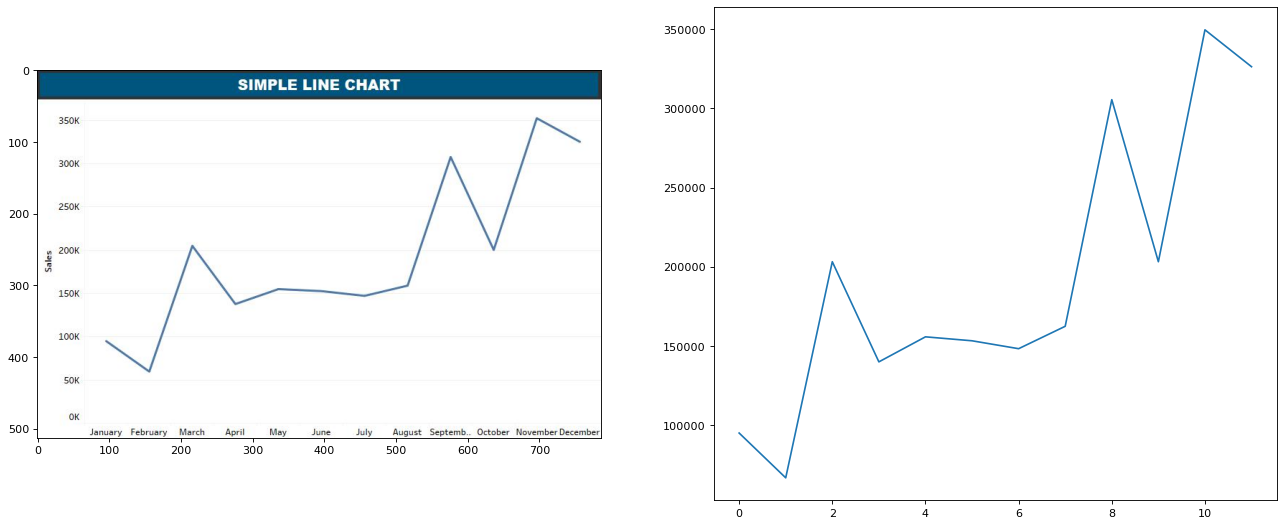

In [39]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
ax[1].plot(y_axis_value)

### Continuous output value of y

In [14]:
# x correspond to y pixel value
y_dic = defaultdict(list)
for i in contours:
    for j in i:
        if x_real_pixel[0] <= j[0][0] <= x_real_pixel[-1] and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
            y_dic[j[0][0]].append(j[0][1])

x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
x_y_value

[(96, [376, 380, 379, 376]),
 (97, [377, 380, 380, 377]),
 (98, [377, 381, 380, 377]),
 (99, [377, 382, 381, 378]),
 (100, [378, 382, 382, 379]),
 (101, [379, 383, 382, 380]),
 (102, [380, 384, 383, 380]),
 (103, [380, 385, 384, 381]),
 (104, [381, 385, 385, 382]),
 (105, [382, 386, 385, 382]),
 (106, [382, 387, 386, 383]),
 (107, [383, 387, 387, 384]),
 (108, [384, 388, 387, 384]),
 (109, [384, 389, 388, 385]),
 (110, [385, 390, 389, 386]),
 (111, [386, 390, 390, 387]),
 (112, [387, 391, 390, 387]),
 (113, [387, 392, 391, 388]),
 (114, [388, 392, 392, 389]),
 (115, [389, 393, 392, 389]),
 (116, [389, 394, 393, 390]),
 (117, [390, 394, 394, 391]),
 (118, [391, 395, 394, 392]),
 (119, [392, 396, 395, 392]),
 (120, [392, 397, 396, 393]),
 (121, [393, 397, 397, 394]),
 (122, [394, 398, 397, 394]),
 (123, [394, 399, 398, 395]),
 (124, [395, 399, 399, 396]),
 (125, [396, 400, 399, 396]),
 (126, [396, 401, 400, 397]),
 (127, [397, 402, 401, 398]),
 (128, [398, 402, 402, 399]),
 (129, [399, 4

In [15]:
x_y_value_mean = []
x_axis_con = []
for i in x_y_value:
    x, y = i
    y_mean = statistics.mean(y)
    x_y_value_mean.append(y_mean)
    x_axis_con.append(x)

In [16]:
# img_w, img_l = original_img.shape[0], original_img.shape[1]
y_pixel_min = y_real_pixel[0]
y_axis_max = int(y_axis[0])
y_axis_max

350000

In [17]:
y_axis_value = []
for i in x_y_value_mean:
    y = (y_pixel_max - i) / (y_pixel_max - y_pixel_min) * y_axis_max
    y = round(y, 2)
    y_axis_value.append(y)
y_axis_value

[95190.02,
 94358.67,
 94358.67,
 93527.32,
 92695.96,
 91864.61,
 91864.61,
 91033.25,
 90201.9,
 90201.9,
 89370.55,
 88539.19,
 88539.19,
 87707.84,
 86876.48,
 86045.13,
 86045.13,
 85213.78,
 84382.42,
 84382.42,
 83551.07,
 82719.71,
 81888.36,
 81888.36,
 81057.01,
 80225.65,
 80225.65,
 79394.3,
 78562.95,
 78562.95,
 77731.59,
 76900.24,
 76068.88,
 76068.88,
 75237.53,
 74406.18,
 74406.18,
 73574.82,
 72743.47,
 71912.11,
 71912.11,
 71080.76,
 70249.41,
 70249.41,
 69418.05,
 68586.7,
 67755.34,
 67755.34,
 66923.99,
 66092.64,
 66092.64,
 65261.28,
 64429.93,
 64429.93,
 63598.57,
 62767.22,
 61935.87,
 61935.87,
 61104.51,
 61104.51,
 62767.22,
 64429.93,
 65261.28,
 66923.99,
 68586.7,
 71912.11,
 74406.18,
 76900.24,
 79394.3,
 81888.36,
 84382.42,
 86876.48,
 89370.55,
 91864.61,
 95190.02,
 95190.02,
 98515.44,
 101009.5,
 103503.56,
 105997.62,
 108491.69,
 110985.75,
 113479.81,
 115973.87,
 119299.29,
 120130.64,
 121793.35,
 125950.12,
 126781.47,
 130106.89,
 132

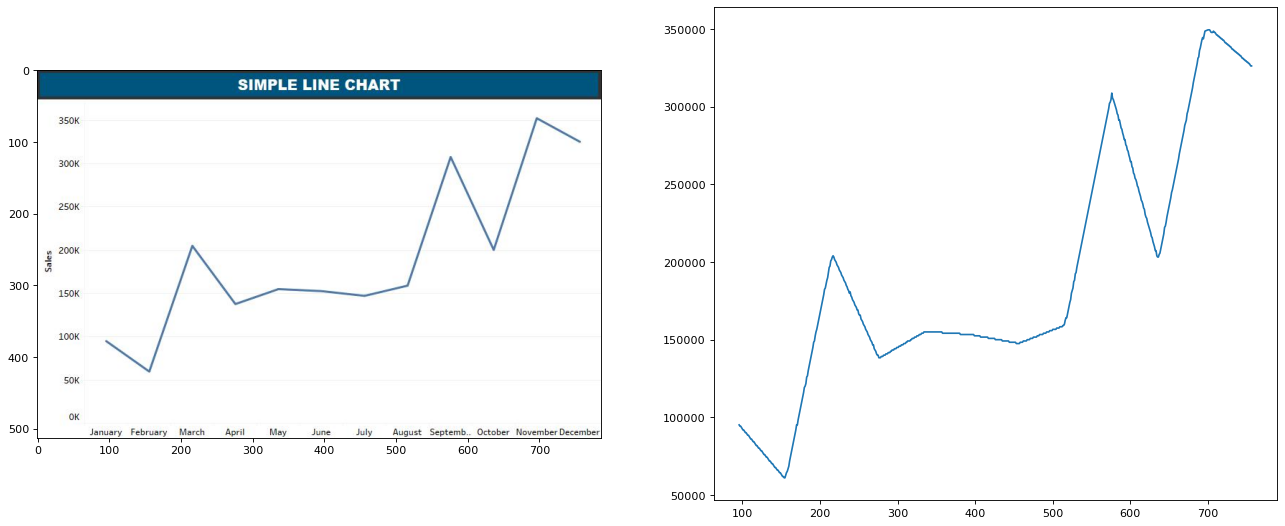

In [22]:

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
ax[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
ax[1].plot(x_axis_con, y_axis_value)

In [78]:
# data = pd.DataFrame(y_label:y_axis_value, columns=x_axis)
data = pd.DataFrame(index=range(1), columns=x_axis_con)
data.iloc[0:] = y_axis_value
data

,96,97,98,99,100,101,102,103,104,105,...,747,748,749,750,751,752,753,754,755,756
0,95190.02,94358.67,94358.67,93527.32,92695.96,91864.61,91864.61,91033.25,90201.9,90201.9,...,330463.18,329631.83,329631.83,328800.48,328800.48,327969.12,327969.12,327137.77,326306.41,326306.41
